Below the use of a class tailored for cross-validating logistic regression, RF and XGBoost classifiers will be demonstrated on the two differing datasets obtained in the repository's data prep section.

For grid search and validation, the evaluation metric will be the $F1$ score, as one could argue from a credit risk standpoint it is more important to strike a balance between precision and recall, than for example to evaluate in terms of ROC-AUC. 

Especially, using roc-auc for these validations would result in models that will severely underpredict credit defaults (in other words, will have a very low recall on the positive class).

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
# Importing the dataset where some of the features were dropped based on t-test results
train_path='/home/RDC/anasashb/Dokumente/brent_price_forecasting/data_prep_and_selection/train_small.pkl' 
test_path='/home/RDC/anasashb/Dokumente/brent_price_forecasting/data_prep_and_selection/test_small.pkl'

with open(train_path, 'rb') as f:
    train = pickle.load(f)

with open(test_path, 'rb') as f:
    test = pickle.load(f)

In [3]:
# Generate sets for predictors and targets
X_train = train.drop('BAD', axis=1)
y_train = train['BAD']
X_test = test.drop('BAD', axis=1)
y_test = test['BAD']

print(f'Train set shapes - X: {X_train.shape}, y: {y_train.shape}\nTest set shapes - X: {X_test.shape}, y: {y_test.shape}')

Train set shapes - X: (1424, 12), y: (1424,)
Test set shapes - X: (245, 12), y: (245,)


In [4]:
# Importing the dataset without excluded features
train_large_path='/home/RDC/anasashb/Dokumente/brent_price_forecasting/data_prep_and_selection/train.pkl' 
test_large_path='/home/RDC/anasashb/Dokumente/brent_price_forecasting/data_prep_and_selection/test.pkl'

with open(train_large_path, 'rb') as f:
    train_large = pickle.load(f)

with open(test_large_path, 'rb') as f:
    test_large = pickle.load(f)

In [5]:
# Generate sets for predictors and targets
X_train_large = train_large.drop('BAD', axis=1)
y_train_large = train_large['BAD']
X_test_large = test_large.drop('BAD', axis=1)
y_test_large = test_large['BAD']

print(f'Train set shapes - X: {X_train_large.shape}, y: {y_train_large.shape}\nTest set shapes - X: {X_test_large.shape}, y: {y_test_large.shape}')

Train set shapes - X: (1424, 18), y: (1424,)
Test set shapes - X: (245, 18), y: (245,)


### **Model Validation Class**

The validation class includes methods to 5-fold cross validate Logistic regression, Random Forest and XGBoost classifiers. Besides, grid search methods are included for RF and XGB. 

In [22]:
# Here we begin defining the class
# Cross-validation will be included in all models

class ModelValidator:
    '''
    A custom class to wrap up model k-fold validation functionalities.
    '''

    # Defining initial arguments
    def __init__(self, X, y):
        # Defining initial class inputs as self arguments
        self.X = X
        self.y = y

    def Logit_validate(self):
        '''
        Fits a Logistic regression model given predictors and a target. 
        
        Args:
            alpha: The L2 penalty value - also called lambda for Ridge Regression.
            tuning: Boolean argument. If set to True, a grid search will be carried out for alpha values
                between 0.01 and 1 with step size of 0.01. 
                Note that setting to 0 (linear regression without any penalties ) will cause model to break down.
        Returns:
            logit_scores: An array of 15 F1 scores obtained from fitting the five folds three times. 
        '''

        # Define cross validation method
        # Use five fold
        cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 66)
        # Set up model
        model = LogisticRegression()

        # To avoid scaling dummy variables
        non_binary = [col for col in self.X.columns if self.X[col].nunique()>2]
        scaler = ColumnTransformer(
            transformers=[
                ('scale', StandardScaler(), non_binary)
                ],
                remainder='passthrough'
                )  

        # Using make_pipeline for our purposes should ensure there is no data leakage 
        # while scaling the folds
        pipeline = make_pipeline(scaler, model)
        
        # F1 for evaluation, as we don't want low recall on positive class
        logit_scores = cross_val_score(pipeline, self.X, self.y, scoring = 'f1', cv = cv, n_jobs = -1)

        print('Results:')
        print('-'*100)
        print(f'Logistic Regression F1: {np.mean(logit_scores):.4f} | Standard Deviation: {np.std(logit_scores):.4f} |')
        print('='*100)

        return logit_scores
    
    
    def RF_search(self,
                  estimator_range=(50,1001,50),
                  depth_range=(10,51,10)):

        '''
        Simple method to conduct grid search for Random Forest Classifier.
        
        Args:
            estimator_range: (min, max, step) tuple of integers for n_estimators in parameter grid 
            depth_range: (min, max, step) tuple of integers for max_depth in parameter grid 
        Returns:
            best_estimator, best_score
        '''
        # Set up cv
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=66)
        # Set up model 
        model = RandomForestClassifier(random_state=66)
        # Set up grid
        param_grid = {
            'n_estimators': list(range(estimator_range[0], estimator_range[1], estimator_range[2])),
            'max_depth': list(range(depth_range[0], depth_range[1], depth_range[2]))
        }
        # Set up search
        search = GridSearchCV(model, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)
        # Run search
        search.fit(self.X, self.y)
        print('Results:')
        print('-'*100)
        print(f'Best RF F1 score: {search.best_score_:.4f}')
        print(f'Best Parameters: {search.best_params_}')
        print('='*100)
        
        return search.best_estimator_, search.best_score_

    def RF_validate(self,
                    n_estimators = 100,
                    max_depth = 20,
                    min_samples_split = 2,
                    max_features = 'sqrt'):
        '''
        Fits and cross validates Random Forest classification model given predictors and a target.

        Args:
            n_estimators: How many trees to include in the ensemble (100 by default)
            max_depth: Maximum depth of a tree (20 by default)
            min_samples_split: Minimum amount of samples to split a node (2 by default)
            max_features: Number of features to consider when searching for best split ('sqrt' by default)

        Returns:
            rf_scores: An array of 15 F1 scores obtained from fitting the five folds three times.

        '''
        # Set up CV
        cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 66)
        model = RandomForestClassifier(n_estimators = n_estimators,
                                      max_depth = max_depth,
                                      min_samples_split = min_samples_split,
                                      max_features = max_features,
                                      random_state = 66
                                      )
        # Same scoring
        rf_scores = cross_val_score(model, self.X, self.y, scoring = 'f1', cv = cv, n_jobs = -1)
        
        print('Results:')
        print('-'*100)
        print(f'RF Classifier F1: {np.mean(rf_scores):.4f} | Standard Deviation: {np.std(rf_scores):.4f} |')
        print('='*100)

        return rf_scores
    

    def XGB_search(self,
                  estimator_range=(50,1001,50),
                  depth_range=(2,11,1),
                  lr_range=[0.01, 0.05, 0.1, 0.3, 0.5]):

        '''
        Simple method to conduct grid search for XGBoost Classifier.
        
        Args:
            estimator_range: (min, max, step) tuple of integers for n_estimators in parameter grid 
            depth_range: (min, max, step) tuple of integers for max_depth in parameter grid
            lr_range: list of floats for learning_rate in param grid 
        Returns:
            best_estimator, best_score
        '''
        # Set up cv
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=66)
        # Set up model 
        model = XGBClassifier(eval_metric='logloss', random_state=66)
        # Set up grid
        param_grid = {
            'n_estimators': list(range(estimator_range[0], estimator_range[1], estimator_range[2])),
            'max_depth': list(range(depth_range[0], depth_range[1], depth_range[2])),
            'learning_rate': lr_range
        }
        # Set up search
        search = GridSearchCV(model, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)
        # Run search
        search.fit(self.X, self.y)
        print('Results:')
        print('-'*100)
        print(f'Best XGB F1 score: {search.best_score_:.4f}')
        print(f'Best Parameters: {search.best_params_}')
        print('='*100)
        
        return search.best_estimator_, search.best_score_        
    
    def XGB_validate(self,
                    n_estimators = 500,
                    max_depth = 5,
                    learning_rate=0.3):
        '''
        Fits an extreme gradient boosting classification model given predictors and a target.

        Args:
            n_estimators: How many trees to include in the ensemble (500 by default)
            max_depth: Maximum depth of a tree (5 by default)
            learning_rate: Learning rate (0.3 by default)

        Returns:
            xgb_scores: An array of 15 F1 scores obtained from fitting the five folds three times.

        '''
        # Set up CV
        cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 66)
        # Set up model
        model = XGBClassifier(n_estimators = n_estimators,
                                      max_depth = max_depth,
                                      learning_rate=learning_rate,
                                      random_state = 66
                                      )
        # Same pipeline
        # Same scoring
        xgb_scores = cross_val_score(model, self.X, self.y, scoring = 'f1', cv = cv, n_jobs = -1)
        
        print('Results:')
        print('-'*100)
        print(f'XGB Classifier F1: {np.mean(xgb_scores):.4f} | Standard Deviation: {np.std(xgb_scores):.4f} |')
        print('='*100)

        return xgb_scores


### **Validation Runs on Small Dataset**
Below the model validation class is used on train set of the smaller dataset, which had features dropped as per t-test results.

Noteworthy that these are done on upsampled train sets, meaning the performance on the unaltered test set is expected to be worse. 

In [23]:
validating_small = ModelValidator(X_train, y_train)

In [24]:
# Cross validate logit on smaller train set
logit_scores_small = validating_small.Logit_validate()

Results:
----------------------------------------------------------------------------------------------------
Logistic Regression F1: 0.6331 | Standard Deviation: 0.0349 |


In [25]:
# Grid search RF on smaller train set
validating_small.RF_search()

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Results:
----------------------------------------------------------------------------------------------------
Best RF F1 score: 0.7376
Best Parameters: {'max_depth': 20, 'n_estimators': 800}


(RandomForestClassifier(max_depth=20, n_estimators=800, random_state=66),
 0.7375588589300751)

In [26]:
rf_scores_small = validating_small.RF_validate(n_estimators=800,
                                           max_depth=20)

Results:
----------------------------------------------------------------------------------------------------
RF Classifier F1: 0.7376 | Standard Deviation: 0.0202 |


In [27]:
validating_small.XGB_search()

Fitting 15 folds for each of 900 candidates, totalling 13500 fits
Results:
----------------------------------------------------------------------------------------------------
Best XGB F1 score: 0.7313
Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=150, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=66, ...),
 0.7312895186741155)

In [28]:
xgb_scores_small = validating_small.XGB_validate(n_estimators=150, 
                                                 max_depth=10, 
                                                 learning_rate=0.1)

Results:
----------------------------------------------------------------------------------------------------
XGB Classifier F1: 0.7313 | Standard Deviation: 0.0288 |


### **Validation Runs on Large Dataset**
Below the model validation class is used on train set of the larger dataset, which had no features dropped.

In [29]:
validating_large = ModelValidator(X_train_large, y_train_large)

In [30]:
# Cross validate logit on larger train set
logit_scores_large = validating_large.Logit_validate()

Results:
----------------------------------------------------------------------------------------------------
Logistic Regression F1: 0.6431 | Standard Deviation: 0.0355 |


In [31]:
# Grid search RF on smaller train set
validating_large.RF_search()

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
Results:
----------------------------------------------------------------------------------------------------
Best RF F1 score: 0.8000
Best Parameters: {'max_depth': 20, 'n_estimators': 450}


(RandomForestClassifier(max_depth=20, n_estimators=450, random_state=66),
 0.7999717623016694)

In [32]:
rf_scores_large = validating_large.RF_validate(n_estimators=450,
                                           max_depth=20)

Results:
----------------------------------------------------------------------------------------------------
RF Classifier F1: 0.8000 | Standard Deviation: 0.0227 |


In [33]:
validating_large.XGB_search()

Fitting 15 folds for each of 900 candidates, totalling 13500 fits
Results:
----------------------------------------------------------------------------------------------------
Best XGB F1 score: 0.7845
Best Parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 550}


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.01, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=550, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=66, ...),
 0.7844631313024306)

In [34]:
xgb_scores_large = validating_large.XGB_validate(n_estimators=550,
                                                 max_depth=9,
                                                 learning_rate=0.01)

Results:
----------------------------------------------------------------------------------------------------
XGB Classifier F1: 0.7845 | Standard Deviation: 0.0231 |


### **Demo Results**

In [35]:
# Here I generate a data from the scores
scores = [logit_scores_small, logit_scores_large, rf_scores_small, rf_scores_large, xgb_scores_small, xgb_scores_large]
names = ['Logit (small)', 'Logit (large)', 'RF (small)', 'RF (large)', 'XGB (small)', 'XGB (large)']

val_scores = pd.DataFrame(data = np.column_stack(scores), columns = names)
val_scores

,Logit (small),Logit (large),RF (small),RF (large),XGB (small),XGB (large)
0,0.686869,0.652921,0.747331,0.798611,0.750000,0.783784
1,0.664234,0.698529,0.735714,0.805861,0.750000,0.821818
2,0.609023,0.635036,0.762887,0.823944,0.744828,0.804196
3,0.633803,0.650685,0.734694,0.784722,0.680556,0.747475
4,0.578125,0.592885,0.756184,0.817518,0.707143,0.791519
5,0.618868,0.609665,0.719178,0.770318,0.728522,0.763889
6,0.559387,0.575758,0.729927,0.758364,0.696629,0.750929
7,0.671429,0.680556,0.734694,0.823105,0.761905,0.778947
8,0.659722,0.687719,0.761566,0.815331,0.742268,0.797203
9,0.629213,0.631970,0.770318,0.787456,0.782313,0.788732


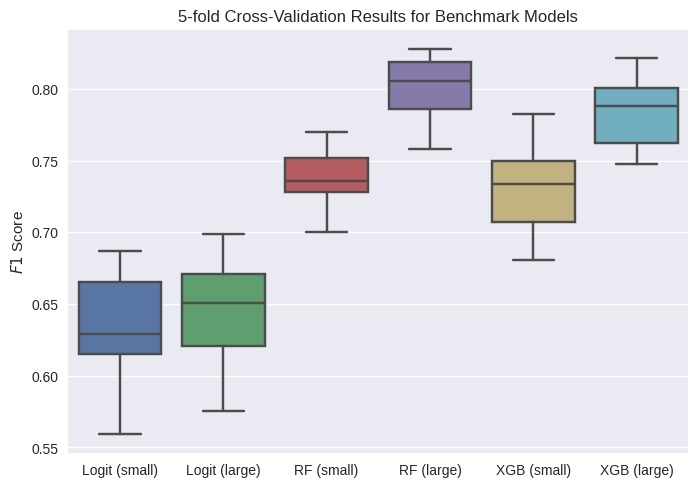

In [36]:
# A bxplot for the results
sns.boxplot(data = val_scores)
plt.title('5-fold Cross-Validation Results for Benchmark Models')
plt.ylabel('$F1$ Score')
plt.show()
plt.close()

As it should be expected, logistic regression's performance suffers from additional features that were shown to be insignificant based on the t-test. Performance of tree-based models increases when including features that were deemed insignificant with the t-test. This is expected due to the non-linear nature of the tree based models, as well as their robustness toward multicolinearity and high dimensionality of features.

For evaluation on the test set, the Random Forest can be used with the large dataset, as it achieved higher average $F1$ score with less variance, all the while having a higher median than its XGB counterpart. 